In [2]:
pip install fosforml

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [6]:
pip install seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import seaborn as sns

In [8]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [9]:
my_session.connection.schema

'CPG_BRONZE'

In [10]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [11]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [12]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [13]:
df=sf_df.to_pandas()

In [14]:
df.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
0,202401,2024-01-18,2024-01-02,1537.89,16,0.001712,1585.454545,202201,DB0706,OL144111,Sedalia,Missouri,City Center,Str4,PRD0064,Hair Care,Conditioner,Bamboo
1,202401,2024-01-28,2024-01-02,518.18,3,0.001125,518.181818,202201,DB0706,OL238706,Williston,North Dakota,City Center,Str1,PRD0113,Perfume and Deodrants,Unisex Deodrant,Navy Blue
2,202401,2024-01-13,2024-01-02,113.64,1,0.000250,113.636364,202201,DB0706,OL223076,Silver City,New Mexico,Santa Cruz,Str1,PRD0107,Lotion,Body Lotion,Coral
3,202401,2024-01-06,2024-01-02,285.71,32,0.000832,285.714286,202201,DB0652,OL175529,Dunkirk,New York,Dolphin,Str3,PRD0147,Kids Care,Baby Cream,Mint
4,202401,2024-01-18,2024-01-02,290.91,1,0.000500,290.909091,202201,DB0652,OL48851,Stroudsburg,Pennsylvania,City Center,Str2,PRD0004,Lotion,Body Lotion,Tan


In [12]:
df.shape

(966400, 18)

In [15]:
#How many % of missing values do we have for each feature?
missing_percentage = df.isnull().sum() / df.shape[0] * 100 
missing_percentage

MNTH_CODE           0.0
TRANS_DATE          0.0
START_DATE          0.0
SALES_VALUE         0.0
SALES_UNITS         0.0
SALES_VOLUME        0.0
SALES_PTR_VALUE     0.0
OC_CODE             0.0
DISTRIBUTOR_CODE    0.0
OUTLET_CODE         0.0
CITY                0.0
STATE               0.0
COUNTY              0.0
STREET              0.0
PRODUCT_CODE        0.0
CATEGORY            0.0
SUBCATEGORY         0.0
BRAND               0.0
dtype: float64

In [14]:
#no any transactions happened without distributer and no outliers/NULL in sales
df.loc[df.DISTRIBUTOR_CODE.isnull(), ["SALES_VOLUME", "SALES_UNITS"]].describe()

,SALES_VOLUME,SALES_UNITS
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [15]:
#no any transactions happened without distributer and no outliers in sales
df.loc[df.OUTLET_CODE.isnull(), ["SALES_VOLUME", "SALES_UNITS"]].describe()

,SALES_VOLUME,SALES_UNITS
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [16]:
df.OUTLET_CODE.nunique()

18833

In [17]:
df.DISTRIBUTOR_CODE.nunique()

5

In [18]:
#no negative sales happened
[df.describe()<0]

[       MNTH_CODE  SALES_VALUE  SALES_UNITS  SALES_VOLUME  SALES_PTR_VALUE  \
 count      False        False        False         False            False   
 mean       False        False        False         False            False   
 std        False        False        False         False            False   
 min        False        False        False         False            False   
 25%        False        False        False         False            False   
 50%        False        False        False         False            False   
 75%        False        False        False         False            False   
 max        False        False        False         False            False   
 
        OC_CODE  
 count    False  
 mean     False  
 std      False  
 min      False  
 25%      False  
 50%      False  
 75%      False  
 max      False  ]

In [16]:
df.isnull().sum()

MNTH_CODE           0
TRANS_DATE          0
START_DATE          0
SALES_VALUE         0
SALES_UNITS         0
SALES_VOLUME        0
SALES_PTR_VALUE     0
OC_CODE             0
DISTRIBUTOR_CODE    0
OUTLET_CODE         0
CITY                0
STATE               0
COUNTY              0
STREET              0
PRODUCT_CODE        0
CATEGORY            0
SUBCATEGORY         0
BRAND               0
dtype: int64

In [17]:
df.duplicated().sum()

3158

In [27]:
df.corr(numeric_only=True)

,MNTH_CODE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE
MNTH_CODE,1.000000,-0.007954,-0.011117,-0.005767,-0.007843,-0.791833
SALES_VALUE,-0.007954,1.000000,0.331870,0.925910,0.996460,0.005674
SALES_UNITS,-0.011117,0.331870,1.000000,0.427627,0.334911,0.013232
SALES_VOLUME,-0.005767,0.925910,0.427627,1.000000,0.927547,0.004323
SALES_PTR_VALUE,-0.007843,0.996460,0.334911,0.927547,1.000000,0.006129
OC_CODE,-0.791833,0.005674,0.013232,0.004323,0.006129,1.000000


In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

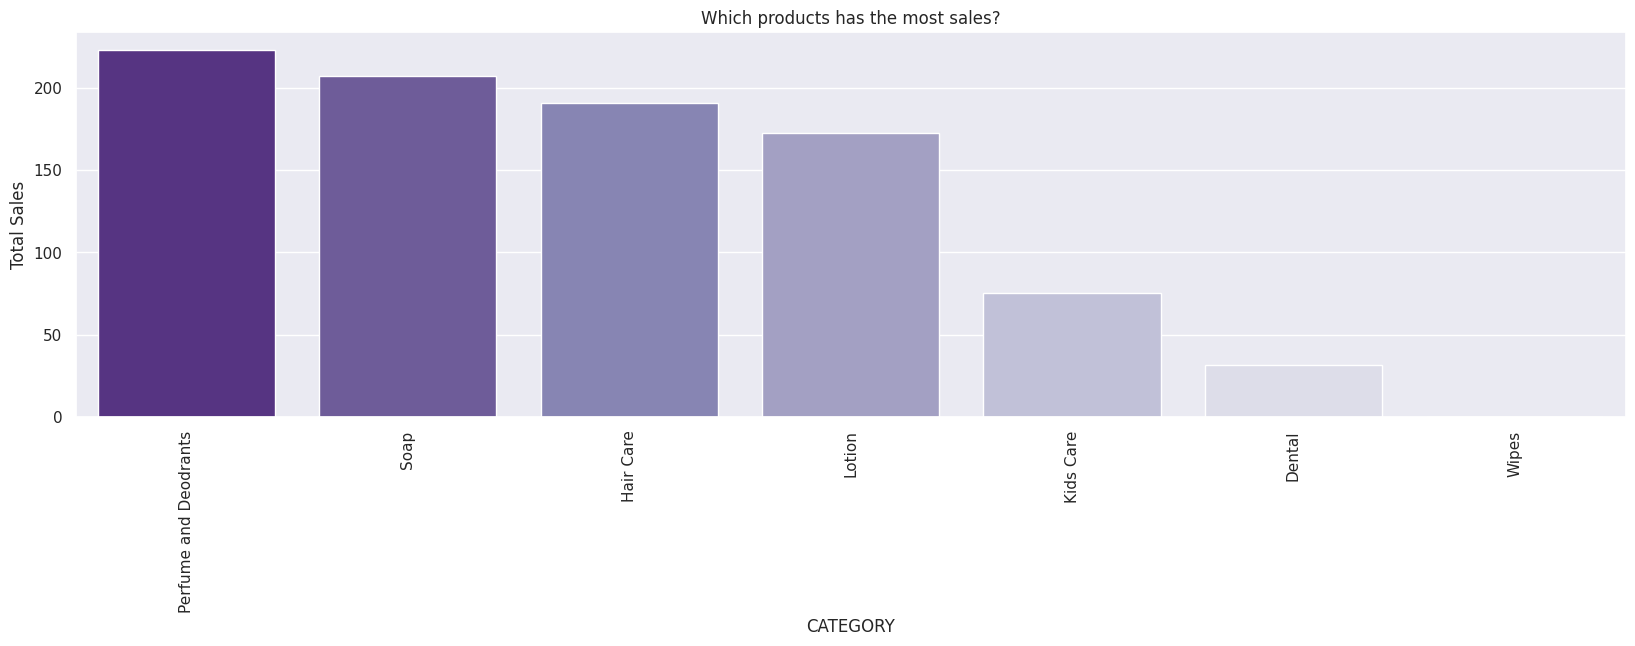

In [20]:

# Group by description and sum the sales
productby_sales = df.groupby('CATEGORY')['SALES_VOLUME'].sum().sort_values(ascending=False).iloc[0:30]

# Plotting
plt.figure(figsize=(20, 5))
sns.barplot(x=productby_sales.index, y=productby_sales.values, palette="Purples_r")
plt.ylabel("Total Sales")
plt.title("Which products has the most sales?")
plt.xticks(rotation=90)
plt.show()


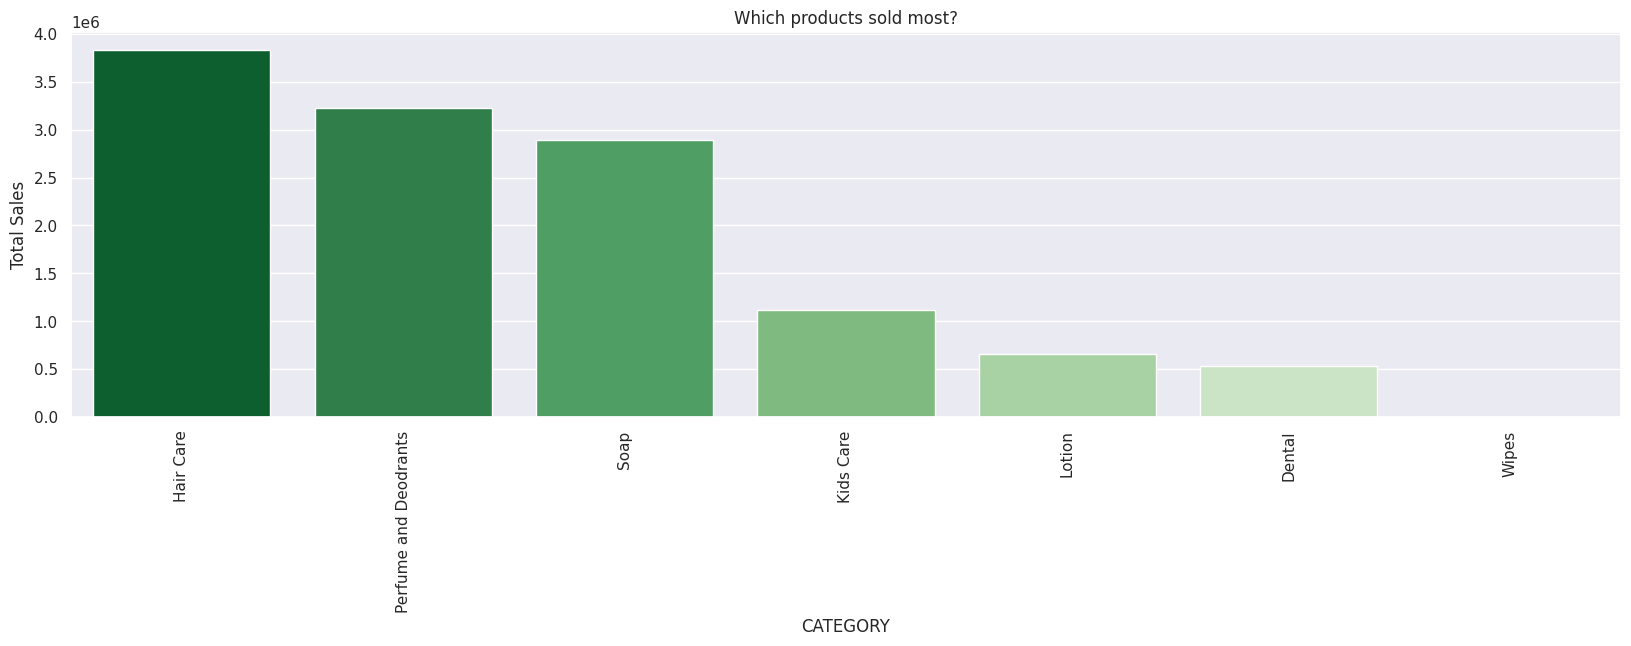

In [21]:

# Group by description and sum the sales
productby_qty = df.groupby('CATEGORY')['SALES_UNITS'].sum().sort_values(ascending=False).iloc[0:30]

# Plotting
plt.figure(figsize=(20, 5))
sns.barplot(x=productby_qty.index, y=productby_qty.values, palette="Greens_r")
plt.ylabel("Total Sales")
plt.title("Which products sold most?")
plt.xticks(rotation=90)
plt.show()


In [18]:
df.COUNTY.nunique()

9

In [25]:
# Find unique dates
df['TRANS_DATE'].nunique()

303

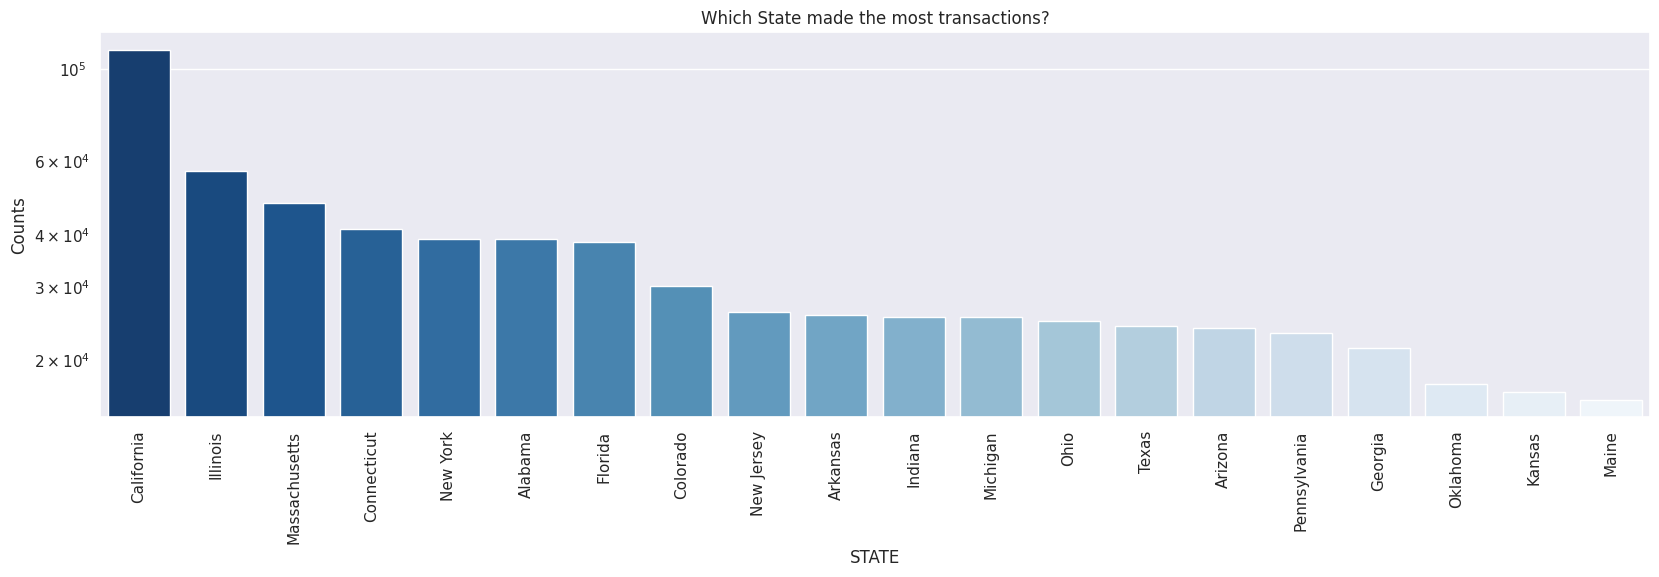

In [34]:
state_counts = df.STATE.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="Blues_r")
plt.ylabel("Counts")
plt.title("Which State made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

In [37]:
#How many percentage of transactions happened in california
df.loc[df.STATE=="California"].shape[0] / df.shape[0] * 100

11.530111754966887

In [39]:
df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

In [40]:
# Create features from date column
df['YEAR'] = df['TRANS_DATE'].dt.year
df['MONTH'] = df['TRANS_DATE'].dt.month
df['DAY'] = df['TRANS_DATE'].dt.day
df['DAY_OF_WEEK'] = df['TRANS_DATE'].dt.day_of_week + 1 # Monday is 1 and sunday is 7
df['QUARTER'] = df['TRANS_DATE'].dt.quarter
df['DAY_OF_YEAR'] = df['TRANS_DATE'].dt.dayofyear

In [41]:
df.describe()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR
count,966400.000000,966400,966400,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000
mean,202372.876450,2024-03-01 03:47:10.976822272,2024-02-14 23:17:36.278145792,446.417454,12.696476,0.000931,457.814679,202206.573263,2023.663032,6.557728,15.405579,4.324140,2.513462,184.151133
min,202309.000000,2023-08-29 00:00:00,2023-08-28 00:00:00,2.860000,1.000000,0.000011,1.785714,202201.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,202312.000000,2023-11-30 00:00:00,2023-11-27 00:00:00,140.000000,2.000000,0.000368,142.857143,202204.000000,2023.000000,4.000000,8.000000,3.000000,2.000000,97.000000
50%,202403.000000,2024-03-03 00:00:00,2024-02-27 00:00:00,192.240000,6.000000,0.000448,198.181818,202207.000000,2024.000000,7.000000,15.000000,5.000000,3.000000,186.000000
75%,202406.000000,2024-06-04 00:00:00,2024-05-29 00:00:00,450.000000,16.000000,0.000900,450.000000,202209.000000,2024.000000,9.000000,23.000000,6.000000,3.000000,271.000000
max,202408.000000,2024-08-27 00:00:00,2024-07-31 00:00:00,145728.120000,10240.000000,0.275500,151800.000000,202212.000000,2024.000000,12.000000,31.000000,7.000000,4.000000,365.000000
std,44.525843,NaN,NaN,1053.355633,40.761336,0.002063,1101.769102,3.404526,0.472674,3.399272,8.632029,1.952907,1.100524,103.703252
